In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [4]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)


/Users/wangyang/Desktop/Liver_cancer/16-AIDD/09_Molecular_Dynamics_Simulation_Analysis/data


In [37]:
md_universe = mda.Universe(str(DATA / "topology.pdb"), str(DATA / "trajectory.xtc"))
view = nv.show_mdanalysis(md_universe)
view

/opt/anaconda3/envs/teachopencadd/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(max_frame=99)

In [38]:
view.render_image(trim=True, factor=2, transparent=True);

In [39]:
view._display_image()

In [40]:
# Set trajectory pointer to first frame as reference
md_universe.trajectory[0]

# in_memory=True is needed to actually modify the loaded trajectory
# if the trajectory is too big for memory, one can write out the aligned trajectory and reload it into a new universe
alignment = align.AlignTraj(
    mobile=md_universe, reference=md_universe, select="protein", in_memory=True
)
alignment.run()

In [41]:
view = nv.show_mdanalysis(md_universe)
view

NGLWidget(max_frame=99)

In [42]:
view.render_image(trim=True, factor=2, transparent=True);

In [43]:
view._display_image()

In [44]:
ligand_name = "03P"

In [45]:
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory[0]
    ref = universe
    rmsd_analysis = rms.RMSD(universe, ref, select=selection1, groupselections=selection2)
    rmsd_analysis.run()
    columns = [selection1, *selection2] if selection2 else [selection1]
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.results.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "frame"
    return rmsd_df

In [46]:
rmsd = rmsd_for_atomgroups(md_universe, "backbone", ["protein", f"resname {ligand_name}"])
rmsd.head()

,backbone,protein,resname 03P
frame,,,
0,0.00,0.00,0.00
1,0.83,1.12,1.72
2,0.96,1.28,1.62
3,0.99,1.36,1.57
4,1.03,1.44,1.51


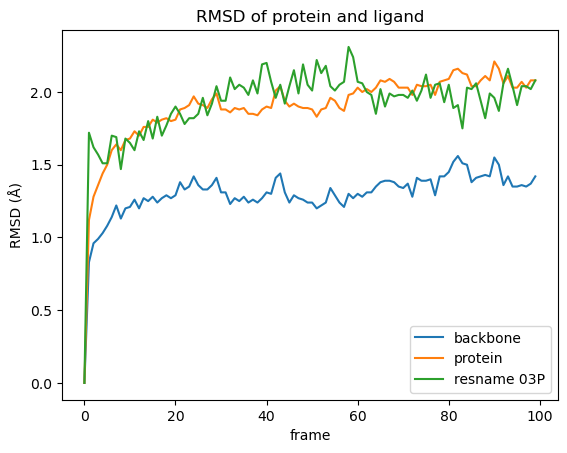

In [47]:
rmsd.plot(title="RMSD of protein and ligand")
plt.ylabel("RMSD (Å)");

In [48]:
def RMSD_dist_frames(universe, selection):
    """Calculate the RMSD between all frames in a matrix.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection: str
        Selection string for the atomgroup to be investigated, also used during alignment.

    Returns
    -------
    array: np.ndarray
        Numpy array of RMSD values.
    """
    pairwise_rmsd = diffusionmap.DistanceMatrix(universe, select=selection)
    pairwise_rmsd.run()
    return pairwise_rmsd.results.dist_matrix

In [49]:
dist_matrix_protein = RMSD_dist_frames(md_universe, "protein")
dist_matrix_ligand = RMSD_dist_frames(md_universe, f"resname {ligand_name}")

In [50]:
# get maximal distance between all frames
max_dist = max(np.amax(dist_matrix_ligand), np.amax(dist_matrix_protein))

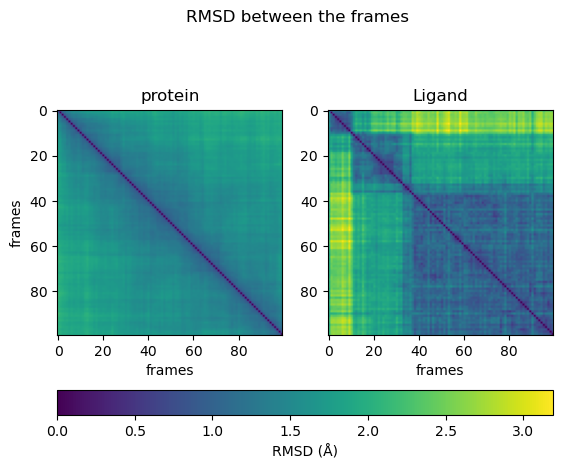

In [51]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("RMSD between the frames")

# protein image
img1 = ax[0].imshow(dist_matrix_protein, cmap="viridis", vmin=0, vmax=max_dist)
ax[0].title.set_text("protein")
ax[0].set_xlabel("frames")
ax[0].set_ylabel("frames")

# ligand image
img2 = ax[1].imshow(dist_matrix_ligand, cmap="viridis", vmin=0, vmax=max_dist)
ax[1].title.set_text("Ligand")
ax[1].set_xlabel("frames")

fig.colorbar(img1, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)");

In [52]:
# select pocket residues
pocket_resids = set(
    md_universe.select_atoms(f"(around 5 resname {ligand_name}) and protein").resids
)
view2 = nv.show_mdanalysis(md_universe)
view2.add_representation(
    "licorice", selection=f"protein and ({' '.join([str(x) for x in pocket_resids])})"
)
view2.center(selection="ligand")
view2

NGLWidget(max_frame=99)

In [53]:
view2.render_image(trim=True, factor=2, transparent=True);

In [54]:
view2._display_image()

In [55]:
protein_residue_id = "793"
protein_atom_name = "N"
ligand_id = "1"
ligand_atom_name = "N4"

In [56]:
atomgroup_protein = md_universe.select_atoms(
    f"resid {protein_residue_id} and name {protein_atom_name}"
)
atomgroup_ligand = md_universe.select_atoms(f"resname {ligand_name} and name {ligand_atom_name}")

In [57]:
distance = dist(atomgroup_protein, atomgroup_ligand)
print(
    f"The distance between residues {protein_residue_id} and {ligand_id} is {distance[2][0]:.2f} Å"
)

The distance between residues 793 and 1 is 3.52 Å


In [58]:
distances = []
for _ in md_universe.trajectory:
    distance = dist(atomgroup_protein, atomgroup_ligand)
    distances.append(distance[2][0])

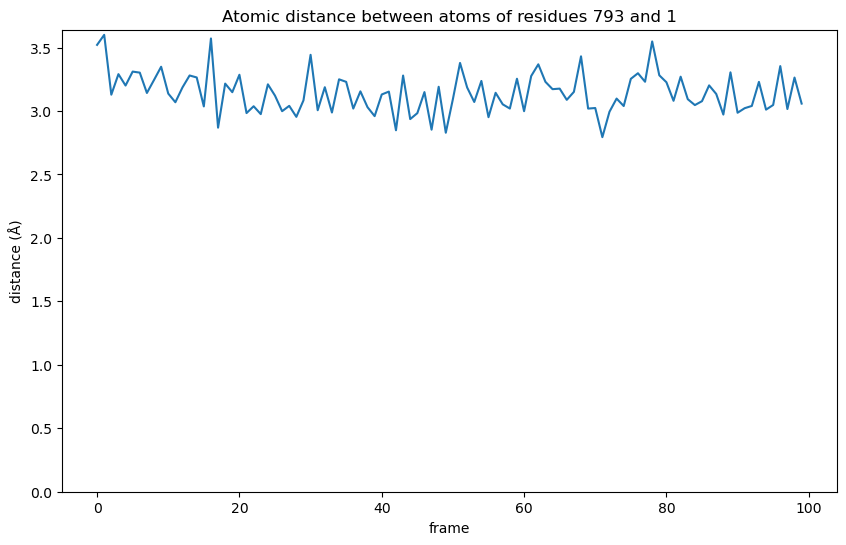

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.gca().set_ylim(bottom=0)
plt.ylabel("distance (Å)")
plt.xlabel("frame")
plt.title(f"Atomic distance between atoms of residues {protein_residue_id} and {ligand_id}")
plt.show()

In [60]:
hydrogen_name = "H"

In [61]:
def run_hydrogenbond_analysis(
    universe,
    donor_resid,
    donor_atom,
    hydrogen_atom,
    acceptor_resid,
    acceptor_atom,
    h_cutoff=1.2,
    a_cutoff=3.0,
    angle_cutoff=120,
):
    """
    Perform an hydrogen bond analysis between selcted atom groups.
    Return the data as readable, formatted data frame.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    donor_resid: str
        Residue Id of residue containing donor atom in MDAnalysis universe.
    donor_atom: str
        Name of the donor atom in the MDAnalysis universe.
    hydrogen_atom: str
        Name of involved hydrogen atom in the MDAnalysis universe.
    acceptor_resid: str
        Residue Id of residue containing acceptor atom in the MDAnalysis universe.
    acceptor_atom: str
        Name of the acceptor atom in the MDAnalysis universe.
    h_cutoff: float, optional
        Distance cutoff used for finding donor-hydrogen pairs.
    a_cutoff: float, optional
        Donor-acceptor distance cutoff for hydrogen bonds.
    angle_cutoff: int, optional
        D-H-A angle cutoff for hydrogen bonds.

    Returns
    -------
    bond : pandas.core.frame.DataFrame
        DataFrame containing hydrogen bond information over time.
    """

    # set up and run the hydrogen bond analysis (HBA)
    hbonds = HBA(
        universe=universe,
        donors_sel="resid " + donor_resid + " and name " + donor_atom,
        hydrogens_sel="resid " + donor_resid + " and name " + hydrogen_atom,
        acceptors_sel="resid " + acceptor_resid + " and name " + acceptor_atom,
        d_h_cutoff=h_cutoff,
        d_a_cutoff=a_cutoff,
        d_h_a_angle_cutoff=angle_cutoff,
    )
    hbonds.run()
    # extract bond data
    bond = pd.DataFrame(np.round(hbonds.results.hbonds, 2))
    # name columns (according to MDAnalysis function description)
    bond.columns = [
        "frame",
        "donor_index",
        "hydrogen_index",
        "acceptor_index",
        "distance",
        "angle",
    ]
    # set frame as the index
    bond["frame"] = bond["frame"].astype(int)
    bond.set_index("frame", inplace=True, drop=True)
    return bond

In [62]:
bond = run_hydrogenbond_analysis(
    md_universe, protein_residue_id, protein_atom_name, hydrogen_name, ligand_id, ligand_atom_name
)
bond.head()

/opt/anaconda3/envs/teachopencadd/lib/python3.8/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:722: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, resid 793 and name N, and Acceptor, resid 1 and name N4.
  warnings.warn(
/opt/anaconda3/envs/teachopencadd/lib/python3.8/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:751: UserWarning: No hydrogen bonds were found given angle of 120 between Donor, resid 793 and name N, and Acceptor, resid 1 and name N4.
  warnings.warn(


,donor_index,hydrogen_index,acceptor_index,distance,angle
frame,,,,,
17,1483.0,1484.0,5529.0,2.87,144.73
21,1483.0,1484.0,5529.0,2.98,162.87
23,1483.0,1484.0,5529.0,2.98,173.41
26,1483.0,1484.0,5529.0,3.00,175.31
28,1483.0,1484.0,5529.0,2.95,163.73


In [63]:
bond = run_hydrogenbond_analysis(
    md_universe,
    protein_residue_id,
    protein_atom_name,
    hydrogen_name,
    ligand_id,
    ligand_atom_name,
    a_cutoff=5.0,
)
bond.head()

,donor_index,hydrogen_index,acceptor_index,distance,angle
frame,,,,,
0,1483.0,1484.0,5529.0,3.52,166.39
1,1483.0,1484.0,5529.0,3.60,145.63
2,1483.0,1484.0,5529.0,3.13,173.95
3,1483.0,1484.0,5529.0,3.29,151.99
4,1483.0,1484.0,5529.0,3.20,170.21


In [64]:
def plot_hydrogen_bond_over_time(bond):
    """
    Plot the distance and degree of a chosen hydrogen bond over time.
    Peaks in angle and dips in distance represent moments of strong binding.

    Parameters
    ----------
    bond: pandas.core.frame.DataFrame
        Hydrogen bond analysis data frame with named columns.
    """

    donor_index = bond.iloc[0].donor_index
    acceptor_index = bond.iloc[0].acceptor_index

    # add values for missing frames for gapless plotting
    bond = bond.reindex(np.arange(0, 99))

    # plot the data
    fig = plt.figure(figsize=(10, 6))
    distance = bond.distance.plot(
        title=f"H-Bond between donor {donor_index} and acceptor {acceptor_index}",
        style="o-",
        x="frame",
    )
    distance.set_ylabel("distance (Å)")
    distance.set_xlabel("frame")
    distance.set_ylim(bottom=0)
    angle = bond.angle.plot(secondary_y=True, style="o-", x="frame")
    angle.set_ylabel("angle (°)")
    angle.set_xlabel("frame")
    angle.set_ylim(bottom=0)
    fig.legend(loc="lower right", bbox_to_anchor=(1, 0), bbox_transform=distance.transAxes)
    plt.show()

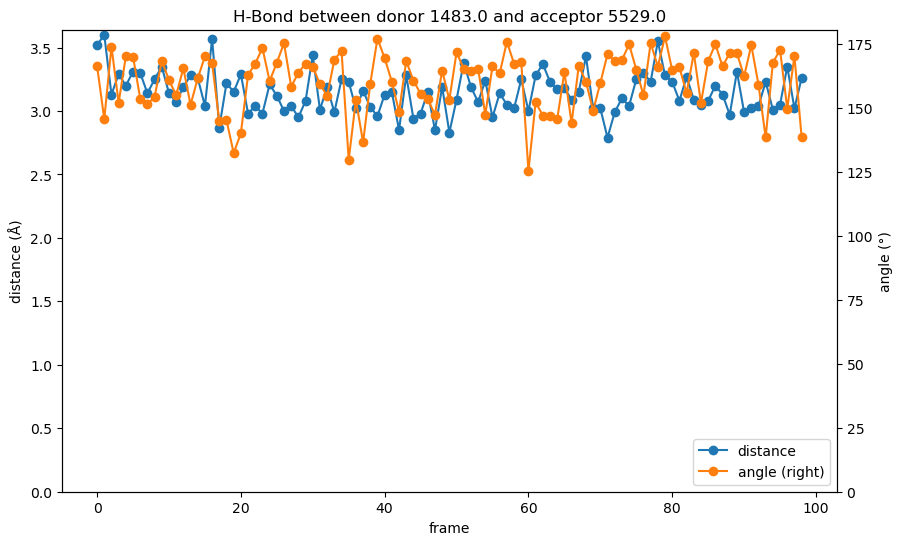

In [65]:
plot_hydrogen_bond_over_time(bond)

In [66]:
view_strong = nv.show_mdanalysis(md_universe)
view_strong.add_representation("ball+stick", selection=f"protein and {protein_residue_id}")
view_strong.center(selection="ligand")
view_strong.frame = 71
view_strong

NGLWidget(frame=71, max_frame=99)

In [67]:
view_bad = nv.show_mdanalysis(md_universe)
view_bad.add_representation("ball+stick", selection=f"protein and {protein_residue_id}")
view_bad.center(selection="ligand")
view_bad.frame = 1
view_bad

NGLWidget(frame=1, max_frame=99)